# Predicting CVD: BE 188 Final Project

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns; sns.set()
import pandas as pd
import numpy as np
import copy

from sklearn.utils import resample
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFECV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.metrics import r2_score
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_curve, roc_auc_score

from sklearn.exceptions import DataConversionWarning
import warnings
warnings.filterwarnings(action='ignore', category = DataConversionWarning)

#### Import and Arrange Data

In [2]:
train_values = np.loadtxt("train_values.csv", delimiter=",", dtype=object)
train_labels = np.loadtxt("train_labels.csv", delimiter=",", dtype=object)

d = np.empty(15, dtype=object)

d[0],d[1],d[2],d[3],d[4],d[5],d[6],d[7],d[8],d[9],d[10],d[11],d[12],d[13] = np.hsplit(train_values, 14)
d[0],d[14] = np.hsplit(train_labels, 2)

atributes = {}

for n,obj in enumerate(d):
    atributes[n] = obj[0][0]
    d[n] = np.squeeze(d[n])[1:]

#NOTE: the columns lable in pd.df is numeric. For a given column N, its property corresponds to atributes[N+1]
data = pd.DataFrame(data=d[1],index=d[0])
for n in range(15):
    if n < 2:
        continue
    data[n-1] = d[n]

#### The 14 features are described below:

- slope_of_peak_exercise_st_segment (type: int): the slope of the peak exercise ST segment, an electrocardiography read out indicating quality of blood flow to the heart
- thal (type: categorical): results of thallium stress test measuring blood flow to the heart, with possible values normal, fixed_defect, reversible_defect
- resting_blood_pressure (type: int): resting blood pressure
- chest_pain_type (type: int): chest pain type (4 values)
- num_major_vessels (type: int): number of major vessels (0-3) colored by flourosopy
- fasting_blood_sugar_gt_120_mg_per_dl (type: binary): fasting blood sugar > 120 mg/dl
- resting_ekg_results (type: int): resting electrocardiographic results (values 0,1,2)
- serum_cholesterol_mg_per_dl (type: int): serum cholestoral in mg/dl
- oldpeak_eq_st_depression (type: float): oldpeak = ST depression induced by exercise relative to rest, a measure of abnormality in electrocardiograms
- sex (type: binary): 0: female, 1: male
- age (type: int): age in years
- max_heart_rate_achieved (type: int): maximum heart rate achieved (beats per minute)
- exercise_induced_angina (type: binary): exercise-induced chest pain (0: False, 1: True)
- heart_disease_present (type: binary): 0: heart disease not present, 1: heart disease present 

NOTE: The index in data corresponds to patient ID

In [3]:
print(atributes)
data.head()

{0: 'patient_id', 1: 'slope_of_peak_exercise_st_segment', 2: 'thal', 3: 'resting_blood_pressure', 4: 'chest_pain_type', 5: 'num_major_vessels', 6: 'fasting_blood_sugar_gt_120_mg_per_dl', 7: 'resting_ekg_results', 8: 'serum_cholesterol_mg_per_dl', 9: 'oldpeak_eq_st_depression', 10: 'sex', 11: 'age', 12: 'max_heart_rate_achieved', 13: 'exercise_induced_angina', 14: 'heart_disease_present'}


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0z64un,1,normal,128,2,0,0,2,308,0.0,1,45,170,0,0
ryoo3j,2,normal,110,3,0,0,0,214,1.6,0,54,158,0,0
yt1s1x,1,normal,125,4,3,0,2,304,0.0,1,77,162,1,1
l2xjde,1,reversible_defect,152,4,0,0,0,223,0.0,1,40,181,0,1
oyt4ek,3,reversible_defect,178,1,0,0,2,270,4.2,1,59,145,0,0


## Data Exploration

In [4]:
# Counts for heart_disease_present in training data
data[13].value_counts()

0    100
1     80
Name: 13, dtype: int64

In [5]:
# Average for each attribute whether or not heart_disease_present
data = (data.astype({0: 'float64', 1: 'category', 2: 'float64', 3: 'float64', 4: 'float64', 5: 'float64', 6: 'float64', 7: 'float64',
                    8: 'float64', 9: 'float64', 10: 'float64', 11: 'float64', 12: 'float64', 13: 'int64'}))
data.groupby(13).mean()

,0,2,3,4,5,6,7,8,9,10,11,12
13,,,,,,,,,,,,
0,1.3600,130.12,2.8100,0.33,0.1600,0.9200,245.46,0.62700,0.5500,53.66,156.87,0.13
1,1.7875,132.80,3.5875,1.15,0.1625,1.2125,253.90,1.48875,0.8625,56.25,140.25,0.55


In [6]:
# Averages as separated by thalium stress test
data.groupby(1).mean()

,0,2,3,4,5,6,7,8,9,10,11,12,13
1,,,,,,,,,,,,,
fixed_defect,2.000000,141.375000,3.125000,0.625000,0.375000,1.250000,227.250000,1.300000,1.000000,57.875000,136.000000,0.250000,0.500000
normal,1.377551,129.775510,2.897959,0.530612,0.153061,1.071429,250.255102,0.669388,0.510204,54.387755,154.938776,0.153061,0.204082
reversible_defect,1.729730,132.256757,3.500000,0.918919,0.148649,1.000000,250.202703,1.429730,0.891892,55.040541,143.716216,0.540541,0.756757


#### Encode Categorical Data with Numerical Labels

In [7]:
category_col = data.select_dtypes(['category']).columns 
data[category_col] = data[category_col].apply(lambda x: x.cat.codes)
print(data.head())

         0   1      2    3    4    5    6      7    8    9     10     11   12  \
0z64un  1.0   1  128.0  2.0  0.0  0.0  2.0  308.0  0.0  1.0  45.0  170.0  0.0   
ryoo3j  2.0   1  110.0  3.0  0.0  0.0  0.0  214.0  1.6  0.0  54.0  158.0  0.0   
yt1s1x  1.0   1  125.0  4.0  3.0  0.0  2.0  304.0  0.0  1.0  77.0  162.0  1.0   
l2xjde  1.0   2  152.0  4.0  0.0  0.0  0.0  223.0  0.0  1.0  40.0  181.0  0.0   
oyt4ek  3.0   2  178.0  1.0  0.0  0.0  2.0  270.0  4.2  1.0  59.0  145.0  0.0   

        13  
0z64un   0  
ryoo3j   0  
yt1s1x   1  
l2xjde   1  
oyt4ek   0  


In [8]:
#created a dict to refernce states
thal = {0:'fixed_defect', 1:'normal', 2:'reversible_defect'}
data.groupby(13).mean()

,0,1,2,3,4,5,6,7,8,9,10,11,12
13,,,,,,,,,,,,,
0,1.3600,1.14,130.12,2.8100,0.33,0.1600,0.9200,245.46,0.62700,0.5500,53.66,156.87,0.13
1,1.7875,1.65,132.80,3.5875,1.15,0.1625,1.2125,253.90,1.48875,0.8625,56.25,140.25,0.55


In [9]:
X = data.loc[:, data.columns != 13]
y = np.array(data.loc[:, data.columns == 13]).reshape(180,)
print(X.head())
X.shape

         0   1      2    3    4    5    6      7    8    9     10     11   12
0z64un  1.0   1  128.0  2.0  0.0  0.0  2.0  308.0  0.0  1.0  45.0  170.0  0.0
ryoo3j  2.0   1  110.0  3.0  0.0  0.0  0.0  214.0  1.6  0.0  54.0  158.0  0.0
yt1s1x  1.0   1  125.0  4.0  3.0  0.0  2.0  304.0  0.0  1.0  77.0  162.0  1.0
l2xjde  1.0   2  152.0  4.0  0.0  0.0  0.0  223.0  0.0  1.0  40.0  181.0  0.0
oyt4ek  3.0   2  178.0  1.0  0.0  0.0  2.0  270.0  4.2  1.0  59.0  145.0  0.0


(180, 13)

## Intial Models

#### Logisitical Regression Classifier

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
logreg = LogisticRegression(multi_class = 'multinomial', solver='newton-cg', penalty='l2', max_iter=10000, C=1)

# Fit the model with taining data
logreg.fit(X_train,y_train) 
y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)
print(f'Accuracy of logistic regression classifier on test set: {logreg.score(X_test, y_test)}')
lloss = log_loss(y_test, y_pred_prob)
print(f'log loss: {lloss}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.8333333333333334
log loss: 0.4260083754982158
[[18  6]
 [ 0 12]]
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        24
           1       0.67      1.00      0.80        12

   micro avg       0.83      0.83      0.83        36
   macro avg       0.83      0.88      0.83        36
weighted avg       0.89      0.83      0.84        36



#### SVM Classifiers

In [11]:
# Linear SVC
svclassifier = SVC(kernel='linear')  
svclassifier.fit(X_train, y_train)  
y_pred = svclassifier.predict(X_test)  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred))  

[[18  6]
 [ 1 11]]
              precision    recall  f1-score   support

           0       0.95      0.75      0.84        24
           1       0.65      0.92      0.76        12

   micro avg       0.81      0.81      0.81        36
   macro avg       0.80      0.83      0.80        36
weighted avg       0.85      0.81      0.81        36



In [13]:
# Polyniminal SVC
svclassifier1 = SVC(kernel='poly', degree=3, gamma = 'auto', max_iter=10000000)  
svclassifier1.fit(X_train, y_train) 
y_pred = svclassifier1.predict(X_test)  
print(confusion_matrix(y_test,y_pred))  
print(classification_report(y_test,y_pred)) 

[[19  5]
 [ 1 11]]
              precision    recall  f1-score   support

           0       0.95      0.79      0.86        24
           1       0.69      0.92      0.79        12

   micro avg       0.83      0.83      0.83        36
   macro avg       0.82      0.85      0.82        36
weighted avg       0.86      0.83      0.84        36



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=10000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


## Feature Selection

#### RFECV with Logistical Regression estimator

In [21]:
logreg = LogisticRegression(multi_class = 'multinomial', solver='newton-cg', penalty='l2', max_iter=10000)
rfe1 = RFECV(logreg)
rfe1 = rfe1.fit(X_train, y_train)
print('Number of Features Selected:', rfe1.n_features_)
print('Mask of Features Selected:', rfe1.support_)
print('Ranking of Features:', rfe1.ranking_)
print('Cross Validation Scores:', rfe1.grid_scores_)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Number of Features Selected: 8
Mask of Features Selected: [ True  True False  True  True  True False False  True  True False False
  True]
Ranking of Features: [1 1 3 1 1 1 2 6 1 1 5 4 1]
Cross Validation Scores: [0.71577833 0.6936333  0.74342042 0.74355611 0.7361684  0.72937774
 0.79261048 0.80621593 0.79246876 0.75049452 0.77799489 0.77813661
 0.77857384]


#### RFECV with SVM estimator

In [22]:
svclassifier = SVC(kernel='linear')  
rfe2 = RFECV(svclassifier, cv = 3)
rfe2 = rfe2.fit(X_train, y_train)
print('Number of Features Selected:', rfe2.n_features_)
print('Mask of Features Selected:', rfe2.support_)
print('Ranking of Features:', rfe2.ranking_)
print('Cross Validation Scores:', rfe2.grid_scores_)

Number of Features Selected: 8
Mask of Features Selected: [ True  True False  True  True  True False False  True  True False False
  True]
Ranking of Features: [1 1 3 1 1 1 2 6 1 1 4 5 1]
Cross Validation Scores: [0.72272278 0.72272278 0.71592609 0.7299567  0.75079606 0.75817171
 0.79956699 0.8206898  0.81331416 0.77134595 0.77134595 0.79232101
 0.77872763]


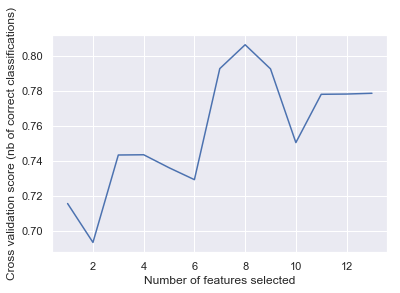

In [28]:
# Plot number of features vs. cross-validation scores
#NOTE: Both our models seem to select the same features!
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfe.grid_scores_) + 1), rfe.grid_scores_)
plt.show()

In [30]:
mainfeatures_not = []
for n, i in enumerate(rfe1.support_):
    if not i:
        mainfeatures_not.append(n)
        continue;
    if not rfe2.support_[n]:
        mainfeatures_not.append(n)

data8 = copy.deepcopy(data)
data8.drop(axis=1, labels=mainfeatures , inplace=True)
data8.head()

,0,1,3,4,5,8,9,12,13
0z64un,1.0,1,2.0,0.0,0.0,0.0,1.0,0.0,0
ryoo3j,2.0,1,3.0,0.0,0.0,1.6,0.0,0.0,0
yt1s1x,1.0,1,4.0,3.0,0.0,0.0,1.0,1.0,1
l2xjde,1.0,2,4.0,0.0,0.0,0.0,1.0,0.0,1
oyt4ek,3.0,2,1.0,0.0,0.0,4.2,1.0,0.0,0


In [31]:
print("\nThese the 8 selected Key features:\n")
for n,i in enumerate(rfe1.support_):
    if i:
        print(atributes[n+1])


These the 8 selected Key features:

slope_of_peak_exercise_st_segment
thal
chest_pain_type
num_major_vessels
fasting_blood_sugar_gt_120_mg_per_dl
oldpeak_eq_st_depression
sex
exercise_induced_angina


## Parameter Optimization

## Model Building (we should probs remove this, idk what even goes here)

## K-fold Cross Validation

###### NOTE: The code below has lines that will save the resulting figures to your local drive. Make sure these lines are commented out if you DO NOT want to save the figures to your local drive.

In [32]:
#Using 80-fold Stratified crossvalidaion
skf = StratifiedKFold(n_splits=80) 
X = data8.loc[:, data8.columns != 13]
y = np.array(data8.loc[:, data8.columns == 13]).reshape(180,)

### The code below is NOT using optimized params for SCV and LogReg, please run the code with the correct params (remove this when this issue is addressed)

In [ ]:
#Running CV for optimized Logistic regression and saving results to local drive
logreg_opt = LogisticRegression(multi_class = 'multinomial', solver='newton-cg', penalty='l2', max_iter=10000, C=0.02)
y_pred = np.zeros(180)
y_pred_prob = np.zeros((180,2))

for train, test in skf.split(X,y):
    logreg_opt.fit(X.iloc[train],y[train])
    y_pred[test] = logreg_opt.predict(X.iloc[test])
    y_pred_prob[test] = logreg_opt.predict_proba(X.iloc[test])
    
lloss = log_loss(y, y_pred_prob)
print(f'log loss: {lloss}')
hplotls = sns.heatmap(confusion_matrix(y,y_pred),annot=True, cmap = 'coolwarm')
fig1 = hplotls.get_figure()

print(classification_report(y,y_pred)) 

logit_roc_auc = roc_auc_score(y, y_pred)
fpr, tpr, thresholds = roc_curve(y, y_pred_prob[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#print(logreg1.coef_)
plt.show()


######Comment out the code below to not save results to local drive
fig1.savefig('hplotlreg.png',dpi=5000)
plt.savefig('roclreg.png',dpi=5000)
######

In [ ]:
#Running CV for optimized SVC and saving results to local drive
svc_opt = SVC(kernel='poly', degree=3, gamma = 'auto', C=0.05,)  
y_predsvm = np.zeros(180)

for train, test in skf.split(X,y):
    svc_opt.fit(X.iloc[train],y[train])
    y_predsvm[test] = svc_opt.predict(X.iloc[test])
    #y_pred_prob[test] = svc1.predict_proba(X.iloc[test])
    
#lloss = log_loss(y, y_pred_prob)
#print(f'log loss: {lloss}')

hplotsvm = sns.heatmap(confusion_matrix(y,y_predsvm),annot=True, cmap = 'coolwarm')
fig2 = hplotls.get_figure()

print(classification_report(y,y_predsvm)) 

logit_roc_auc = roc_auc_score(y, y_predsvm)
fpr, tpr, thresholds = roc_curve(y, y_predsvm)
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

######Comment out the code below to not save results to local drive
fig2.savefig('hplotsvm.png',dpi=5000)
plt.savefig('rocsvm.png',dpi=5000)
######

## Prediction and Submission for Contest